In [1]:
import os
import random
import numpy as np
import pandas as pd
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# 1. 시드 고정 (재현성)
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# 2. 데이터 로드 & 메타데이터
hdf5_path = "C:/Users/pc/Downloads/archive/merge.hdf5"
csv_path  = "C:/Users/pc/Downloads/archive/merge.csv"

df = pd.read_csv(csv_path)
df['p_arrival_sample'] = df['p_arrival_sample'].fillna(0).astype(int)

with h5py.File(hdf5_path, "r") as f:
    trace_names = list(f["data"].keys())

column_trace_name       = df["trace_name"].tolist()
column_p_arrival_sample = df["p_arrival_sample"].tolist()
column_trace_category   = df["trace_category"].tolist()
trace_to_index = {name: i for i, name in enumerate(column_trace_name)}

print("총 Trace 개수:", len(trace_names))

C:\Users\pc\AppData\Local\Temp\ipykernel_472\2565404767.py:5: DtypeWarning: Columns (7,11,13,14,24,25,26,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


총 Trace 개수: 1265657


In [4]:
# 3. Train/Val/Test Split (60:20:20)
all_idx = np.arange(len(trace_names))
train_idx, tmp_idx = train_test_split(all_idx, test_size=0.40, random_state=seed)
val_idx, test_idx  = train_test_split(tmp_idx,    test_size=0.50, random_state=seed)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

Train: 759394, Val: 253131, Test: 253132


In [5]:
# 4. tf.data 파이프라인 + Trace 정규화
batch_size = 32

def make_dataset(indices, shuffle=True):
    def gen():
        # HDF5 파일을 열고 각 인덱스의 데이터를 읽어옴
        with h5py.File(hdf5_path, 'r') as f:
            for idx in indices:
                data = f[f"data/{trace_names[idx]}"][...]  
                mi   = trace_to_index[trace_names[idx]]
                label_t = column_p_arrival_sample[mi]
                label_p = int(column_trace_category[mi] == "earthquake_local")
                yield data, label_t, label_p

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec((6000, 3), tf.float32),
            tf.TensorSpec((),       tf.int32),
            tf.TensorSpec((),       tf.int32),
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=10000, seed=seed)

    def normalize_trace(x):
        mean = tf.reduce_mean(x, axis=0, keepdims=True)
        std  = tf.math.reduce_std(x, axis=0, keepdims=True) + 1e-6
        return (x - mean) / std

    def preprocess(x, t, p):
        x_norm = normalize_trace(x)
        ew = tf.expand_dims(x_norm[:, 0], axis=-1)
        ns = tf.expand_dims(x_norm[:, 1], axis=-1)
        vt = tf.expand_dims(x_norm[:, 2], axis=-1)
        return (
            {"ew": ew, "ns": ns, "v": vt},
            {"arrival_time": t, "presence": p}
        )

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_idx, shuffle=True)
val_ds   = make_dataset(val_idx,   shuffle=False)
test_ds  = make_dataset(test_idx,  shuffle=False)

In [6]:
# 5. Conv1D → LSTM 모델 정의
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, LSTM, Concatenate, Dropout, Dense
from tensorflow.keras.models import Model

def build_cnn_lstm_model():
    in_ew = Input(shape=(6000, 1), name="ew")
    in_ns = Input(shape=(6000, 1), name="ns")
    in_v  = Input(shape=(6000, 1), name="v")

    # EW 채널 블록
    x1 = Conv1D(filters=32, kernel_size=16, strides=4, padding='same', activation='relu')(in_ew)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling1D(pool_size=4, padding='same')(x1)
    x1 = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x1)

    # NS 채널 블록
    x2 = Conv1D(filters=32, kernel_size=16, strides=4, padding='same', activation='relu')(in_ns)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling1D(pool_size=4, padding='same')(x2)
    x2 = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x2)

    # V 채널 블록
    x3 = Conv1D(filters=32, kernel_size=16, strides=4, padding='same', activation='relu')(in_v)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling1D(pool_size=4, padding='same')(x3)
    x3 = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x3)

    # Concatenate + Dropout
    x = Concatenate()([x1, x2, x3])
    x = Dropout(0.3)(x)

    # 회귀 출력 (arrival_time)
    out_t = Dense(1, name="arrival_time", dtype="float32")(x)

    # 분류 출력 (presence)
    out_p = Dense(1, activation="sigmoid", name="presence")(x)

    model = Model(inputs=[in_ew, in_ns, in_v], outputs=[out_t, out_p])
    model.compile(
        optimizer="adam",
        loss={"arrival_time": "mse", "presence": "binary_crossentropy"},
        metrics={"arrival_time": "mae", "presence": "accuracy"}
    )
    return model

model = build_cnn_lstm_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ew (InputLayer)                [(None, 6000, 1)]    0           []                               
                                                                                                  
 ns (InputLayer)                [(None, 6000, 1)]    0           []                               
                                                                                                  
 v (InputLayer)                 [(None, 6000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1500, 32)     544         ['ew[0][0]']                     
                                                                                              

In [7]:
# 6. 학습 설정
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

epochs = 100

early_stop = EarlyStopping(
    monitor='val_arrival_time_mae',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_arrival_time_mae',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# 한 에폭당 1000배치만 사용 (약 1000×32 = 32,000개 샘플)
steps_per_epoch = 1000
validation_steps = 200

history = model.fit(
    train_ds.take(steps_per_epoch),
    validation_data=val_ds.take(validation_steps),
    epochs=epochs,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
1000/1000 [==============================] - 1837s 2s/step - loss: 276884.7500 - arrival_time_loss: 276884.3438 - presence_loss: 0.4082 - arrival_time_mae: 463.7576 - presence_accuracy: 0.8680 - val_loss: 201240.0000 - val_arrival_time_loss: 201239.6406 - val_presence_loss: 0.3521 - val_arrival_time_mae: 397.5577 - val_presence_accuracy: 0.8814 - lr: 0.0010
Epoch 2/100
1000/1000 [==============================] - 1816s 2s/step - loss: 157781.3125 - arrival_time_loss: 157780.9375 - presence_loss: 0.3678 - arrival_time_mae: 347.6469 - presence_accuracy: 0.8835 - val_loss: 119033.0469 - val_arrival_time_loss: 119032.6797 - val_presence_loss: 0.3485 - val_arrival_time_mae: 295.3545 - val_presence_accuracy: 0.8891 - lr: 0.0010
Epoch 3/100
1000/1000 [==============================] - 1792s 2s/step - loss: 98434.6250 - arrival_time_loss: 98434.2969 - presence_loss: 0.3463 - arrival_time_mae: 259.6214 - presence_accuracy: 0.8920 - val_loss: 81008.1016 - val_arrival_time_loss: 81007

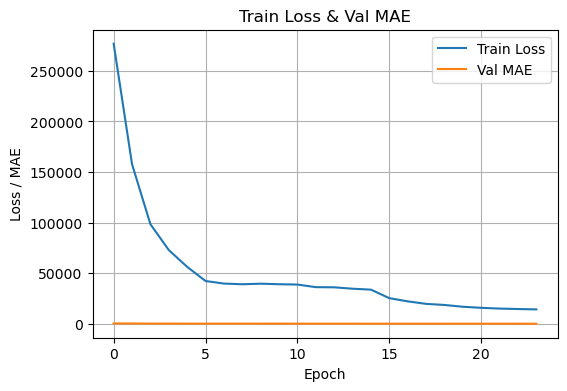

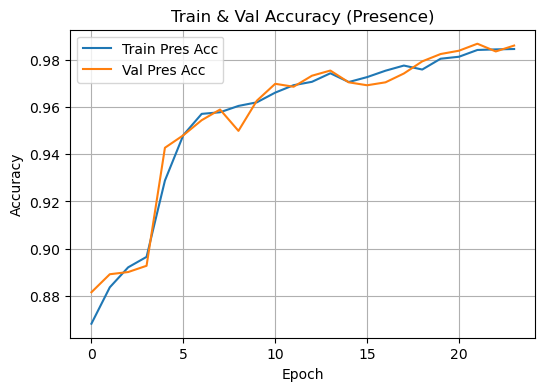

In [10]:
# 7. 학습 곡선 시각화
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],                label="Train Loss")
plt.plot(history.history['val_arrival_time_mae'], label="Val MAE")
plt.xlabel("Epoch"); plt.ylabel("Loss / MAE")
plt.title("Train Loss & Val MAE")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['presence_accuracy'],     label="Train Pres Acc")
plt.plot(history.history['val_presence_accuracy'], label="Val Pres Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Train & Val Accuracy (Presence)")
plt.legend(); plt.grid(True)
plt.show()

In [ ]:

# 8. 테스트(50개 샘플만) 평가 및 샘플별 결과 출력
import numpy as np
import tensorflow as tf
import h5py

# (A) “test_ds”에서 앞 50개 데이터만 뽑아오고, 50개를 하나의 배치로 묶기
small_test_ds_50 = (
    test_ds
    .unbatch()              # 전체 테스트셋을 개별 샘플 단위로 분리
    .take(50)               # 그 중 “첫 50개 샘플”만 선택
    .batch(50, drop_remainder=False)  # 50개를 한 배치로 묶음
)

# (B) 이 50개 샘플만 가지고 평가
test_metrics_50 = model.evaluate(small_test_ds_50, verbose=1)
# 반환값: [total_loss, arrival_time_loss, presence_loss, arrival_time_mae, presence_acc]
print(f"\n→ 50개 샘플 Test arrival_time MAE: {test_metrics_50[3]:.4f}, "
      f"Test presence Acc: {test_metrics_50[4]:.4f}\n")

# (C) 테스트 인덱스 첫 50개를 직접 꺼내서 “실제 / 예측 : 차이” 출력
with h5py.File(hdf5_path, 'r') as h5f:
    for i, idx in enumerate(test_idx[:50], start=1):
        try:
            data = h5f[f"data/{trace_names[idx]}"][...]  # (6000, 3)
            print(f"[Sample {i}] raw shape: {data.shape}")

            # NaN 또는 Inf 검사
            if np.isnan(data).any() or np.isinf(data).any():
                print(f"  → Skipped (NaN or Inf detected)")
                continue

            # shape 검사: (6000, 3)이 아니면 건너뜀
            if data.ndim != 2 or data.shape != (6000, 3):
                print(f"  → Skipped (unexpected shape: {data.shape})")
                continue

            # 평균/표준편차 정규화 (선택 사항)
            mean = data.mean(axis=0, keepdims=True)
            std  = data.std(axis=0, keepdims=True) + 1e-6
            x_norm = (data - mean) / std  # shape (6000, 3)

            # 채널별로 (1, 6000, 1) 형태로 변환
            ew = tf.expand_dims(x_norm[:, 0], axis=-1)[None, ...]
            ns = tf.expand_dims(x_norm[:, 1], axis=-1)[None, ...]
            vt = tf.expand_dims(x_norm[:, 2], axis=-1)[None, ...]

            # 모델 예측
            pred_t, pred_p = model.predict({"ew": ew, "ns": ns, "v": vt}, verbose=0)
            t_pred = int(round(pred_t[0, 0]))

            # 실제 라벨 가져오기
            mi     = trace_to_index[trace_names[idx]]
            actual = column_p_arrival_sample[mi]
            is_eq  = (column_trace_category[mi] == "earthquake_local")

            # 출력 형식
            if not is_eq:
             print(f"{i}. noise")
            else:
                diff = abs(actual - t_pred)
                print(f"{i}. {actual} / {t_pred} : {diff}")

        except Exception as e:
            print(f"{i}. [Error] Skipped sample idx={idx} → {str(e)}")
            continue


1/1 [==============================] - 2s 2s/step - loss: 12211.6611 - arrival_time_loss: 12211.6123 - presence_loss: 0.0486 - arrival_time_mae: 76.6875 - presence_accuracy: 0.9800

→ 50개 샘플 Test arrival_time MAE: 76.6875, Test presence Acc: 0.9800

[Sample 1] raw shape: (6000, 3)
1. 500 / 619 : 119
[Sample 2] raw shape: (6000, 3)
2. 500 / 638 : 138
[Sample 3] raw shape: (6000, 3)
3. noise
[Sample 4] raw shape: (6000, 3)
4. 400 / 427 : 27
[Sample 5] raw shape: (6000, 3)
5. noise
[Sample 6] raw shape: (6000, 3)
6. noise
[Sample 7] raw shape: (6000, 3)
7. 500 / 564 : 64
[Sample 8] raw shape: (6000, 3)
8. 700 / 765 : 65
[Sample 9] raw shape: (6000, 3)
9. 599 / 643 : 44
[Sample 10] raw shape: (6000, 3)
10. 700 / 727 : 27
[Sample 11] raw shape: (6000, 3)
11. 700 / 383 : 317
[Sample 12] raw shape: (6000, 3)
12. 500 / 452 : 48
[Sample 13] raw shape: (6000, 3)
13. noise
[Sample 14] raw shape: (6000, 3)
14. noise
[Sample 15] raw shape: (6000, 3)
15. 700 / 598 : 102
[Sample 16] raw shape: (6000,